<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## By [@Zaid Alyafeai](https://twitter.com/zaidalyafeai)

In [26]:
#for creating the gif images 
!pip install imageio

# AutoEncoders

Autoencoders automatically consists of two structures: the encoder and the decoder. The encoder network downsamples the data into lower dimensions and the decoder network reconstructs the original data from the lower dimension representation. The lower dimension representation is usually called latent space representation. 

![alt text](https://cdn-images-1.medium.com/max/1000/1*8ixTe1VHLsmKB3AquWdxpQ.png)

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from keras import backend as K
import imageio
import glob 
import os
import cv2
import numpy as np
from keras import regularizers
from keras.datasets import mnist

# QuickDraw10

This is a simpler version of the QuickDraw [dataset](https://github.com/googlecreativelab/quickdraw-dataset) with only 10 classes. 

In [28]:
!git clone https://github.com/zaidalyafeai/QuickDraw10

fatal: destination path 'QuickDraw10' already exists and is not an empty directory.


In [0]:
import numpy as np

train_data = np.load('QuickDraw10/dataset/train-ubyte.npz')
test_data  = np.load('QuickDraw10/dataset/test-ubyte.npz')

x_train, y_train = train_data['a'], test_data['b']
x_test,  y_test  = test_data['a'],  test_data['b']

In [30]:
x_train = np.expand_dims(x_train.astype('float32') / 255., 3)
x_test =  np.expand_dims(x_test.astype('float32') / 255. , 3)

print (x_train.shape)
print (x_test.shape)

(80000, 28, 28, 1)
(20000, 28, 28, 1)


In [0]:
def create_layers():
  layers = []
  size = 32 
  
  #encoder layers
  for i in range(0, 3):
    x = Conv2D(size, (3, 3), activation='relu', padding='same')
    layers += [x] 
    x = MaxPooling2D((2, 2), padding='same')
    layers += [x]
    size = size // 2
  

  #deocder layers 
  for i in range(0, 3):
    size = size * 2
    if i == 2:
      x = Conv2D(size, (3, 3), activation='relu')
    else:
      x = Conv2D(size, (3, 3), activation='relu', padding='same')
    layers += [x]
    x = UpSampling2D((2, 2))
    layers += [x]
    
    
  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
  layers += [x]
  
  return layers

def autoencoder():
  input_img = Input(shape=(28, 28, 1))  

  layers = create_layers()

  #create the auto encoder network 
  x = input_img
  for layer in layers:
    x = layer(x)
    
  autoencoder = Model(input_img, x)
  autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
  
  #create the encoder network
  x = input_img
  for layer in layers[0:6]:
    x = layer(x)
    
  encoder = Model(input_img, x)
  
  #create the decoder network
  input_encoded = Input(shape = (4, 4, 8))
  x = input_encoded
  for layer in layers[6:]:
    x = layer(x)

  decoder = Model(input_encoded, x)
  return autoencoder, encoder, decoder 

In [0]:
autoencoder, encoder, decoder = autoencoder()

In [33]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 10s 131us/step - loss: 37.6875 - val_loss: 31.7834
Epoch 2/100
80000/80000 [==============================] - 10s 123us/step - loss: 30.4358 - val_loss: 29.4910
Epoch 3/100
80000/80000 [==============================] - 10s 123us/step - loss: 28.7532 - val_loss: 28.4551
Epoch 4/100
80000/80000 [==============================] - 10s 123us/step - loss: 27.7314 - val_loss: 27.3340
Epoch 5/100
80000/80000 [==============================] - 10s 123us/step - loss: 27.0483 - val_loss: 26.7529
Epoch 6/100
80000/80000 [==============================] - 10s 124us/step - loss: 26.5147 - val_loss: 26.2360
Epoch 7/100
80000/80000 [==============================] - 10s 119us/step - loss: 26.1219 - val_loss: 25.9180
Epoch 8/100
80000/80000 [==============================] - 10s 123us/step - loss: 25.7940 - val_loss: 25.6367
Epoch 9/100
80000/80000 [==============================] - 10s 123us/s

# Interpolate Between a Batch of Images

Given two images $x_1, x_2$ we want to interpolate between their latent space representations to create some nice affects. The basic idea is that we calculate $v_1 = encoder(x_1)$ and $v_2 = encoder(x_2)$  then we calculate the combination vector $v = x v_1 + (1-x)v_2$ where $x\in [0, 1]$ . Each time we increase the value of the varible $x$ the decoder move from a reconstruction of $x_1$ to a reconstruction of $x_2$. Note that we are using a linear combination here.  

In [0]:
import shutil 

#linear interpolation function 
def f(x):
  return x

def interpolate(size = 10):
  if os.path.exists("images"):
    shutil.rmtree("images")
    os.makedirs('images')
  else:
    os.makedirs('images')
    
  
  
  #get 3 random batches each of size 3 
  batches = []
  for _ in range(0, 3):
    i1 = np.random.randint(0, len(x_train))
    i2 = np.random.randint(0, len(x_train))
    batches.append([x_train[i1:i1+3], x_train[i2:i2+3]])
 
  i = 0   
  for x in list(np.linspace(0, 1, size)):
    frame = None
    j = 0 
    
    #interpolate each batch and concatenate them at the end to create 3x3 images
    for (x1, x2) in batches:
    
      
      v1 = encoder.predict(x1) 
      v2 = encoder.predict(x2)
        
      #use a linear interpolater 
      v = f(x) * v1 + f(1-x) * v2
      
      #get the output and reshape it 
      y = decoder.predict(v)
      img = np.reshape(y, (3 * 28, 28))
      img = img * 255
      
      #concatenate the batches 
      if frame is None:
        frame = img
      else:
        frame = np.concatenate([frame, img], axis = 1)
      j += 1
      
    #write the current frame to the disk 
    frame = cv2.resize(frame, (256, 256))  
    cv2.imwrite(f'images/image{i}.png', frame)
    i+=1

In [0]:
interpolate(size = 10)

# Create a gif of the interpolated images

In [44]:
with imageio.get_writer('lsi.gif', mode='I', duration=0.35) as writer:
  filenames = glob.glob('images/image*.png')
  filenames = sorted(filenames)
  
  for i,filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp lsi.gif lsi.gif.png')

0

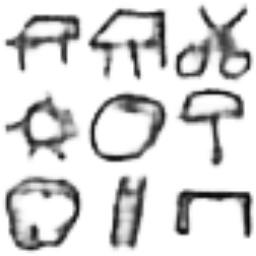

In [45]:
from IPython import display 
display.Image(filename="lsi.gif.png")

# References


*   https://hackernoon.com/autoencoders-deep-learning-bits-1-11731e200694
*   https://blog.keras.io/building-autoencoders-in-keras.html

